In [10]:
# #############################
# #### Run only first time ####
# #############################
install.packages(c("ape","matlab","rJava","devtools","simecol","abc", "fields","robustHD"))
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("timescape")

## To install cloneid, follow instructions at https://github.com/noemiandor/cloneid
## You will need mysql client: https://dev.mysql.com/downloads/workbench/
# export PATH=$PATH:/Applications/MySQLWorkbench.app/Contents/MacOS

## Download SQL database from https://www.cloneredesign.com/data

## Load data into local mysql database
# mysqldump --column-statistics=0  --host=localhost --port=3306  --user=root -p CLONEID > ~/Downloads/CLONEID_V6_20190812_NAR.sql

## Configure cloneid:
library("cloneid")
editCloneidConfig(host='localhost',  user='USERNAME', password='PASS')
# #############################
# #############################

In [ ]:
library(timescape)
library(ape)
library(matlab)
library(RMySQL)
library(cloneid)

In [ ]:



# ############################
# #### Multi-omics module ####
# ############################




Warning message:
“Closing open result sets”

[[1]]
[1] TRUE

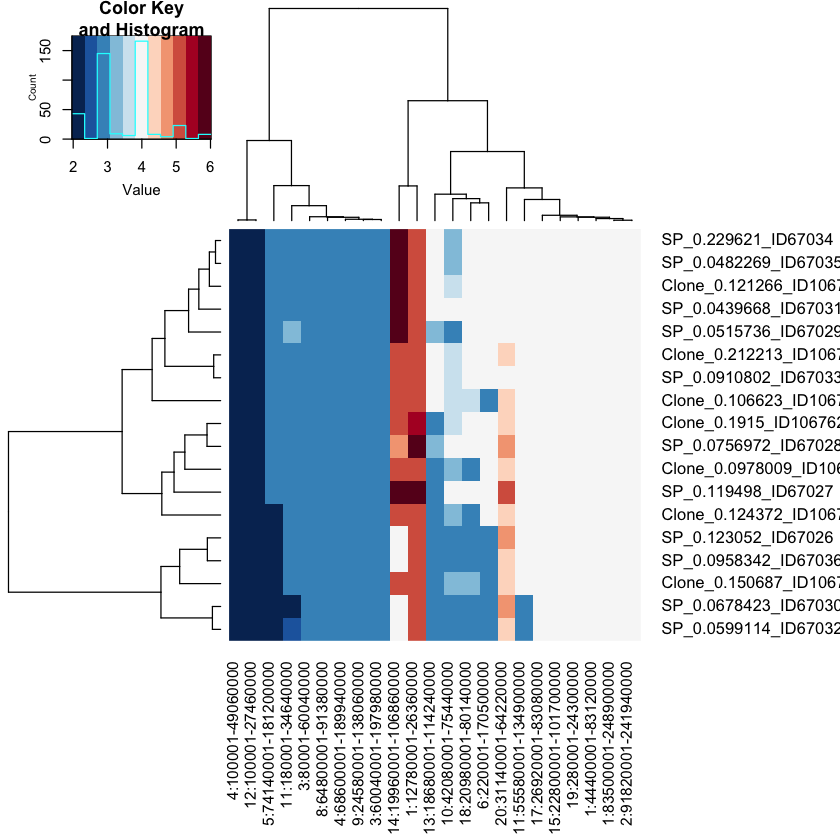

[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Assigning copy number to mutations..."
[1] "... Done."
[1] "Java-Object{Clone_1.0_ID0}"


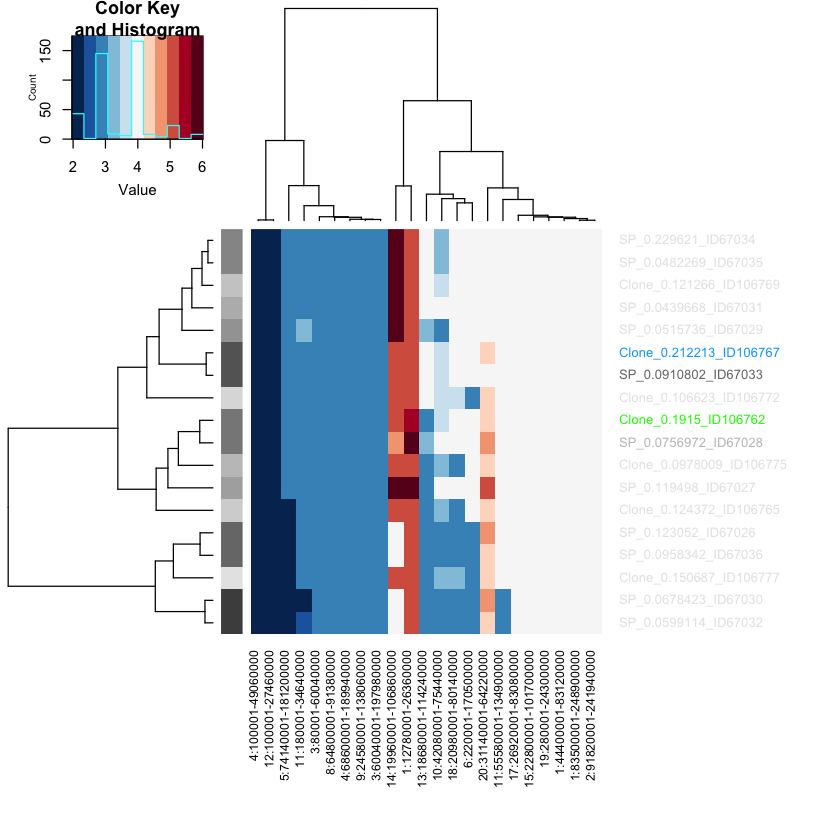

In [11]:
## Trace evolution of coexisting cancer clones within cell line SNU-16 over time
sName = "SNU-16"
DNA = "GenomePerspective"
RNA = "TranscriptomePerspective"

## scRNA-seq derived clone profiles
clones_r = getSubProfiles(sName, whichP = RNA)
## scDNA-seq derived clone profiles
clones_d = getSubProfiles(sName, whichP = DNA)

## Align clones detected with scDNA- and scRNA-seq
try(lapply( dbListConnections( dbDriver( drv = "MySQL")), dbDisconnect))
out = cloneid::merge(c(RNA, DNA),specimens = sName,simM = "euclidean",t=2)

In [14]:
## Passage number at the time of library prep. for scRNA- and scDNA-Seq
cellLines = c("SNU-16")
mydb = connect2DB()
P = list()
for (cellLine in cellLines){
    stmt = paste0("select distinct origin, whichPerspective, passage, sampleName ",
                  "from Perspective t1 join Passaging t2 on t1.origin = t2.id ",
                  "where t1.sampleName =\'", cellLine, "\'")
    rs = dbSendQuery(mydb, stmt); 
    P[[cellLine]] = fetch(rs, n=-1)
}
P = do.call(rbind, P)


## Clonal frequencies at each time point
fr_r = cbind(getSPsize(colnames(clones_r)), as.numeric(extractID(colnames(clones_r))))
fr_d = cbind(getSPsize(colnames(clones_d)), as.numeric(extractID(colnames(clones_d))))
fr = rbind(cbind(fr_r, P$passage[P$whichPerspective==RNA]), cbind(fr_d, P$passage[P$whichPerspective==DNA]))
colnames(fr) = c("clonal_prev", "perspective_id", "timepoint")
fr = as.data.frame(fr)
fr$clone_id = NA; 


## Match clones between scDNA- and scRNA-seq perspectives
tmp = as.data.frame(apply(out$sp2clone, 1, extractID), stringsAsFactors = F)
tmp = tmp[c(DNA,RNA),]
for(cl in colnames(tmp)){
    tmp[,cl] = as.numeric(tmp[,cl])
    fr$clone_id[fr$perspective_id %in% tmp[,cl]] = tmp[1,cl];
}
colnames(clones_d) = extractID(colnames(clones_d)) 
colnames(clones_r) = extractID(colnames(clones_r))
i_r = setdiff(colnames(clones_r), as.character(fr$perspective_id[!is.na(fr$clone_id)]) )
clones = cbind(clones_d[rownames(out$consdat), ], clones_r[rownames(out$consdat), i_r])
fr$clone_id[is.na(fr$clone_id)] = fr$perspective_id[is.na(fr$clone_id)]

In [15]:
## Estimate phyolegentic relations among all clones
tree = ape::bionjs(dist(t(clones)))

In [16]:
## Formatting: Replace leaf ids with tip labels:
tree$tip.label = extractID(tree$tip.label)
ii = which(tree$edge[, 2] <= length(tree$tip.label))
tree$edge[ii, 2] = as.numeric(tree$tip.label[tree$edge[ii, 2]])
tree = as.data.frame(tree$edge)
colnames(tree) = c("source", "target")

In [17]:
## Visualization using timescape:
timescape::timescape(clonal_prev = fr[,c("clonal_prev", "clone_id", "timepoint")], tree_edges = tree)

HTML widgets cannot be represented in plain text (need html)

In [ ]:



# ################################
# #### Lineage-tracing module ####
# ################################




List of 4
 $ edge       : int [1:79, 1:2] 52 53 54 55 56 56 57 58 59 60 ...
 $ edge.length: num [1:79] 1 1 1 1 9 1 1 1 1 11 ...
 $ Nnode      : int 29
 $ tip.label  : chr [1:51] "SNU-16_A2_seedTP24" "SNU-16_A3_harv" "SNU-16_A4_seed" "SNU-16_A8_seedTP24" ...
 - attr(*, "class")= chr "phylo"
 - attr(*, "order")= chr "cladewise"


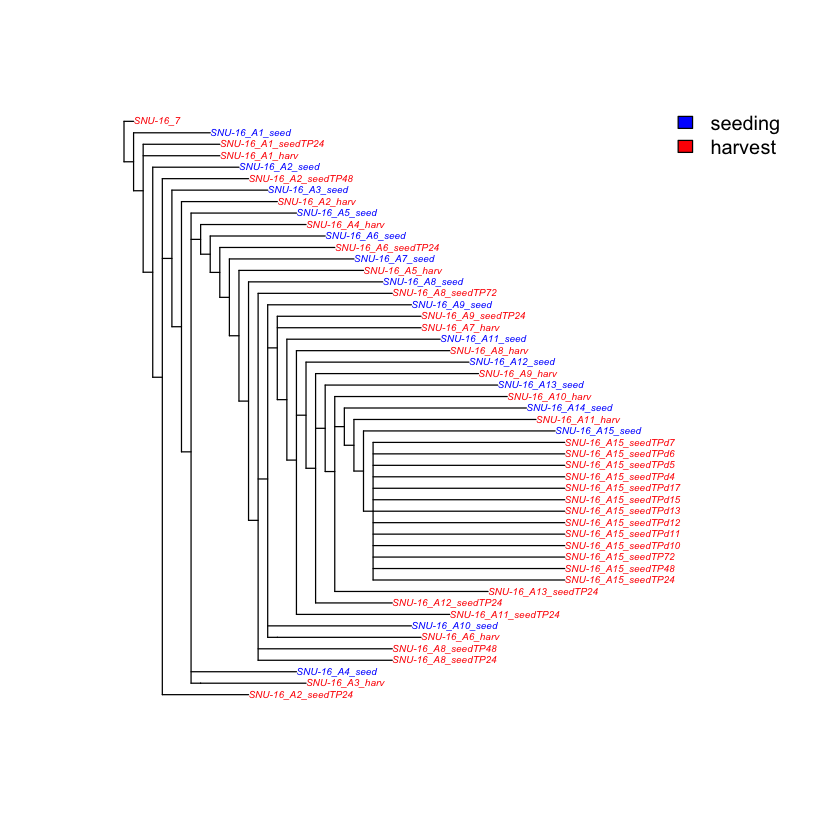

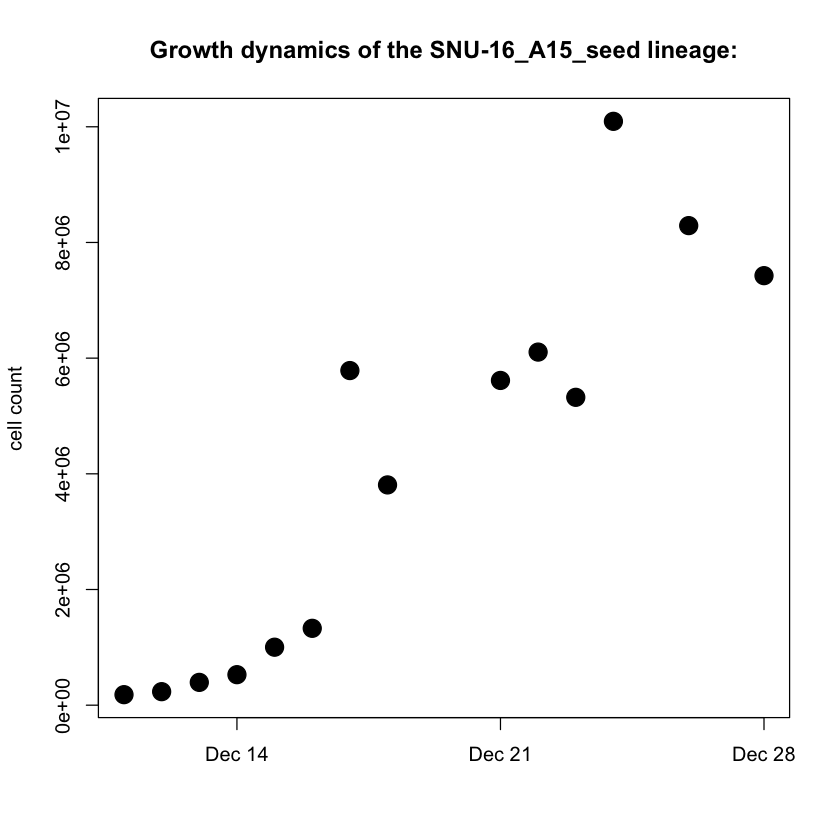

In [19]:
defaultW <- getOption("warn") 
options(warn = -1) 

## Tree depicts how various lineages of the SNU-16 cell line are related to each other. 
tr = getPedigreeTree(id = P$origin[1])
stmt = findAllDescendandsOf(id=P$origin[1],recursive = T); 
rs = RMySQL::dbSendQuery(connect2DB(), stmt)
out = fetch(rs, n=-1)

## Microscopy images were segmented to count number of cells in each lineage at multiple timepoints.
out$daysSinceSeed = NA
for(i in which(out$event=='harvest' & out$passaged_from_id1 %in% out$id)){
    out$daysSinceSeed[i] = as.Date(out$date[i]) - as.Date(out$date[out$id == out$passaged_from_id1[i]])
}

## Longest uninterrupted growth:
lineage = out$passaged_from_id1[ which.max(out$daysSinceSeed)]
stmt = findAllDescendandsOf(id = lineage, recursive = F); 
rs = dbSendQuery(connect2DB(), stmt)
out = fetch(rs, n=-1)
plot(as.Date(out$date), out$cellCount, pch = 20, cex=3, log="", col="black", xlab="", ylab="cell count", main=paste0("Growth dynamics of the ", lineage, " lineage:") )

options(warn = defaultW)

